# **Decade of a song from audio features prediction**

Sariel Tutay 206126195

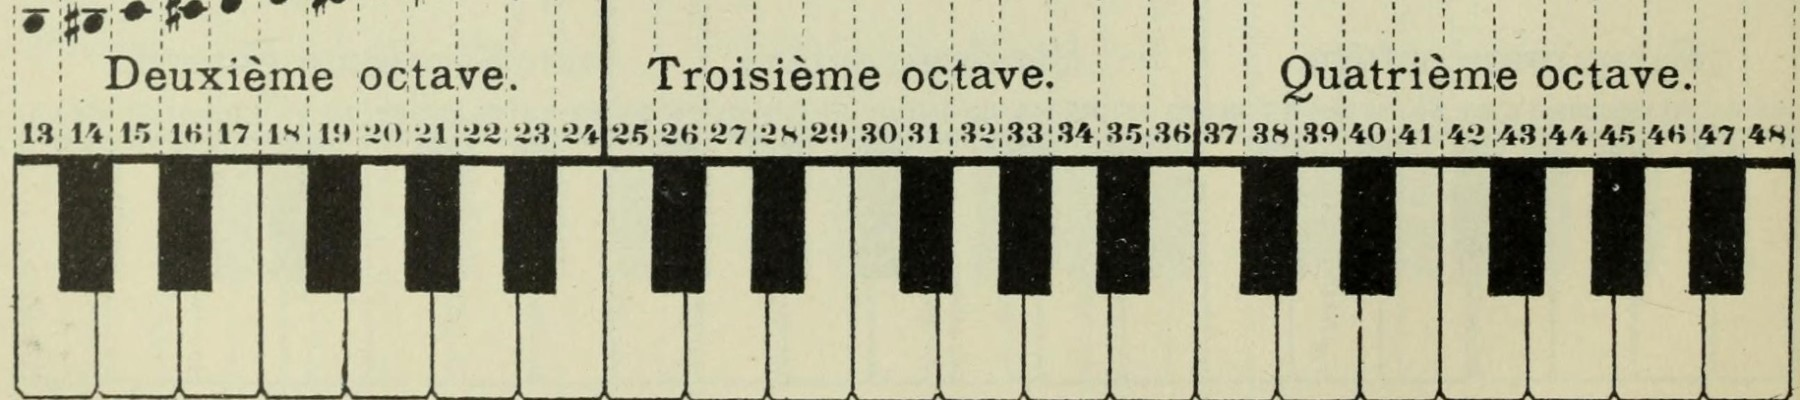


<p style="font-size:18px;">
The Million Song Dataset (MSD) is a freely-available collection of audio features and metadata for a million contemporary popular music tracks. This is a subset of the MSD and contains audio features of songs with the year of the song. The purpose is to predict the release decade of a song from audio features.
</p>

<p style="font-size:18px;">
Field descriptions:
</p>

<ul style="font-size:18px;">
    <li>The first value is the year (target), ranging from 1922 to 2011.</li>
    <li>Then there are 90 attributes:
        <ul>
            <li><strong>TimbreAverage (Attributes 1-12):</strong> These attributes represent the average values of the timbre vectors across all segments of a song. Timbre, often described as the color or texture of music, is quantified here through a 12-dimensional vector. This vector captures the essence of a song's sound in a way that distinguishes it from others.</li>
            <li><strong>TimbreCovariance (Attributes 13-90):</strong> The remaining 78 attributes are derived from the covariance of timbre vectors across all segments of a song. Covariance measures how two variables change together, so these attributes explore the relationship between different dimensions of timbre within a track. This can reveal complex patterns in the music, such as how the presence of certain instruments or rhythms might correlate with others over the course of a song.</li>
        </ul>
    </li>
</ul>

<p style="font-size:18px;">
These features are extracted using The Echo Nest API, which analyzes the audio to break it down into 'segments'—short portions that capture a distinct musical idea or element. By calculating the average and covariance of timbre vectors for these segments, the dataset offers a nuanced and detailed representation of a song's audio characteristics.
</p>


# **Import Python Libraries**

In [343]:
import pandas as pd  # Data manipulation
import numpy as np  # Numerical operations
import seaborn as sns  # Visualization enhancements
import matplotlib.pyplot as plt 

# Model selection and evaluation
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import (classification_report, accuracy_score, 
                             precision_score, recall_score, balanced_accuracy_score, f1_score, make_scorer)

# Models and classifiers
from sklearn.ensemble import RandomForestClassifier
#from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from imblearn.ensemble import BalancedBaggingClassifier

# Resampling techniques
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Data preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder, PowerTransformer
from scipy.stats import skew

# Utility functions and models (assuming these are custom functions defined elsewhere)
from models import (Balanced_Bagging_Classifier, basic_model_and_evaluate, 
                    xgboost_SMOTE_model_and_evaluate, xgboost_model_and_evaluate, 
                    calculate_classification_metrics, get_classification_report_metrics, save_results, load_results, basic_model_and_evaluate)
from utils import cap_extreme_outliers_iqr, cap_with_reference, scale_features
import shap
import pickle
import os
import re

# Warnings
import warnings
warnings.filterwarnings('ignore')

# **Introducing the dataset -- Exploratory Data Analysis (EDA)**

## Load the data

In [346]:
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text for text in re.split(r'(\d+)', s)]

def combine_csvs(input_folder, output_file):
    csv_files = [os.path.join(input_folder, file) for file in os.listdir(input_folder) if file.endswith(".csv")]
    csv_files.sort(key=natural_sort_key)

    with open(output_file, 'w') as f_out:
        for i, file in enumerate(csv_files):
            df = pd.read_csv(file)
            df.to_csv(f_out, index=False, mode='a')
            print(f"Added {file} to {output_file}")

In [347]:
combine_csvs("data", "year_prediction1.csv")

Added data\year_prediction_part_1.csv to year_prediction1.csv
Added data\year_prediction_part_2.csv to year_prediction1.csv
Added data\year_prediction_part_3.csv to year_prediction1.csv
Added data\year_prediction_part_4.csv to year_prediction1.csv
Added data\year_prediction_part_5.csv to year_prediction1.csv
Added data\year_prediction_part_6.csv to year_prediction1.csv
Added data\year_prediction_part_7.csv to year_prediction1.csv
Added data\year_prediction_part_8.csv to year_prediction1.csv
Added data\year_prediction_part_9.csv to year_prediction1.csv
Added data\year_prediction_part_10.csv to year_prediction1.csv
Added data\year_prediction_part_11.csv to year_prediction1.csv
Added data\year_prediction_part_12.csv to year_prediction1.csv
Added data\year_prediction_part_13.csv to year_prediction1.csv
Added data\year_prediction_part_14.csv to year_prediction1.csv
Added data\year_prediction_part_15.csv to year_prediction1.csv
Added data\year_prediction_part_16.csv to year_prediction1.csv
A

In [348]:
audio_data = pd.read_csv('year_prediction1.csv')

In [349]:
audio_data.shape

(515345, 91)

In [350]:
audio_data.head()

,label,TimbreAvg1,TimbreAvg2,TimbreAvg3,TimbreAvg4,TimbreAvg5,TimbreAvg6,TimbreAvg7,TimbreAvg8,TimbreAvg9,...,TimbreCovariance69,TimbreCovariance70,TimbreCovariance71,TimbreCovariance72,TimbreCovariance73,TimbreCovariance74,TimbreCovariance75,TimbreCovariance76,TimbreCovariance77,TimbreCovariance78
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


## Dataset Sizes

In [352]:
audio_data.shape

(515345, 91)

## Columns & Data types

<p style="font-size:16px;">We dell with numeric features<P>

In [355]:
audio_data.dtypes

label                   int64
TimbreAvg1            float64
TimbreAvg2            float64
TimbreAvg3            float64
TimbreAvg4            float64
                       ...   
TimbreCovariance74    float64
TimbreCovariance75    float64
TimbreCovariance76    float64
TimbreCovariance77    float64
TimbreCovariance78    float64
Length: 91, dtype: object

<p style="font-size:16px;">The feature representing the year of the song is labeled as such, so we replace the name of the label feature.<P>

In [357]:
audio_data = audio_data.rename(columns={'label': 'year'})

## Class distribution

In [359]:
audio_data['Decade'] = audio_data.year.apply(lambda year : year-(year%10))
year = audio_data['year']
audio_data.drop('year',axis=1, inplace=True)

In [360]:
X = audio_data.drop('Decade', axis=1)
y = audio_data['Decade'].squeeze()

**<p style="font-size:16px;">To predict the decade, we will transform the 'year' feature into a 'decade' feature.</p>**

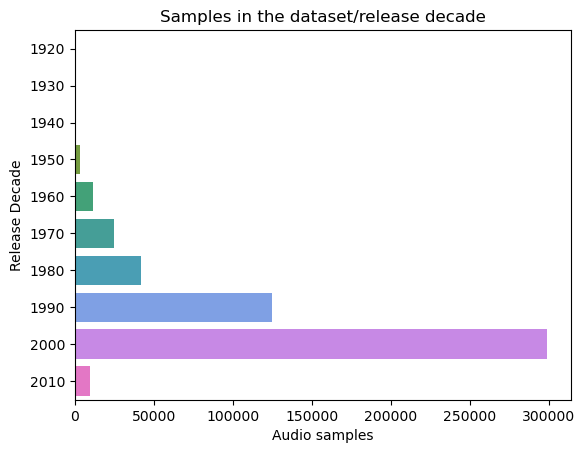

In [362]:
sns.countplot(y="Decade", data=audio_data, palette="husl")
plt.xlabel("Audio samples")
plt.ylabel("Release Decade")
plt.title("Samples in the dataset/release decade")
plt.show()

<p style="font-size:18px;">There's a pronounced skew towards more recent music, with the 2000s being the most densely populated decade, followed by the 1990s. In contrast, the dataset contains relatively few samples from the earlier decades, particularly from the 1920s to the 1950s.</p>

**<p style="font-size:18px;">This imbalance presents a potential challenge for predictive modeling which may develop a bias towards predicting newer decades. The underrepresentation of older songs could lead to poorer predictive performance for these time periods. Therefore, addressing this imbalance through appropriate resampling methods or model adjustments will be a crucial step in the pipeline to ensure that our model does not favor more recent decades over older ones.</p>**

In [364]:
nan_counts = audio_data.isna().sum()
nan_counts[nan_counts > 0]

Series([], dtype: int64)

**<p style="font-size:18px;">There are no missing values.<p style="font-size:18px;">**

In [366]:
audio_data.describe()

,TimbreAvg1,TimbreAvg2,TimbreAvg3,TimbreAvg4,TimbreAvg5,TimbreAvg6,TimbreAvg7,TimbreAvg8,TimbreAvg9,TimbreAvg10,...,TimbreCovariance70,TimbreCovariance71,TimbreCovariance72,TimbreCovariance73,TimbreCovariance74,TimbreCovariance75,TimbreCovariance76,TimbreCovariance77,TimbreCovariance78,Decade
count,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,...,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000
mean,43.387126,1.289554,8.658347,1.164124,-6.553601,-9.521975,-2.391089,-1.793236,3.727876,1.882385,...,-73.461500,41.542422,37.934119,0.315751,17.669213,-26.315336,4.458641,20.035136,1.329105,1993.376534
std,6.067558,51.580351,35.268585,16.322790,22.860785,12.857751,14.571873,7.963827,10.582861,6.530232,...,175.618889,122.228799,95.050631,16.161764,114.427905,173.977336,13.346557,185.558247,22.088576,10.815839
min,1.749000,-337.092500,-301.005060,-154.183580,-181.953370,-81.794290,-188.214000,-72.503850,-126.479040,-41.631660,...,-4402.376440,-1810.689190,-3098.350310,-341.789120,-3168.924570,-4319.992320,-236.039260,-7458.378150,-381.424430,1920.000000
25%,39.954690,-26.059520,-11.462710,-8.487500,-20.666450,-18.440990,-10.780600,-6.468420,-2.293660,-2.444850,...,-139.555160,-20.986900,-4.669540,-6.781590,-31.580610,-101.530300,-2.566090,-59.509270,-8.820210,1990.000000
50%,44.258500,8.417850,10.476320,-0.652840,-6.007770,-11.188390,-2.046670,-1.736450,3.822310,1.783520,...,-53.090060,28.791060,33.623630,0.820840,15.598470,-21.204120,3.117640,7.759730,0.053050,2000.000000
75%,47.833890,36.124010,29.764820,8.787540,7.741870,-2.388960,6.508580,2.913450,9.961820,6.147220,...,13.478730,89.661770,77.785800,8.470990,67.794960,52.389330,9.967740,86.351610,9.679520,2000.000000
max,61.970140,384.065730,322.851430,335.771820,262.068870,166.236890,172.402680,126.741270,146.297950,60.345350,...,4469.454870,3210.701700,1734.079690,260.544900,3662.065650,2833.608950,463.419500,7393.398440,677.899630,2010.000000


<p style="font-size:18px;">The features show considerable variation in scale, necessitating data standardization.</p>

## Correlation

<p style="font-size:18px;">We aim to analyze which feature demonstrates the strongest correlation with the 'Decade' feature.</p>

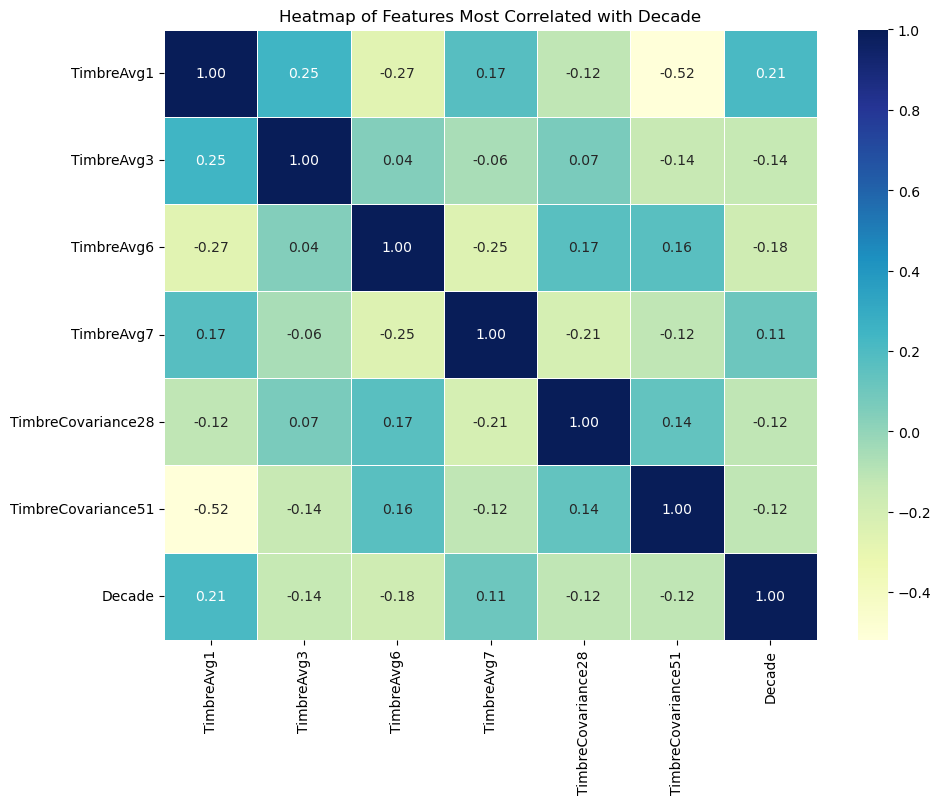

In [370]:
correlation_matrix = audio_data.corr()

# Filter out features with a strong correlation to 'Decade'
threshold = 0.1
most_corrs_with_decade = correlation_matrix['Decade'][abs(correlation_matrix['Decade']) >= threshold]
features_with_most_correlation = most_corrs_with_decade.index.tolist()
smaller_corr_matrix = audio_data[features_with_most_correlation].corr()


plt.figure(figsize=(10, 8))
sns.heatmap(smaller_corr_matrix, annot=True, cmap="YlGnBu", cbar=True, linewidths=0.5, fmt=".2f")
plt.tight_layout() 
plt.title('Heatmap of Features Most Correlated with Decade')
plt.show()

<p style="font-size:18px;">The feature TimbreAvg1, which has the highest correlation, shows a positive correlation (0.21) with the Decade. This suggests that its values tend to increase in more recent music, making it potentially significant for predicting the release decade.</p>

<p style="font-size:18px;">We observe that most features have relatively low correlation values, both positive and negative, with the Decade. This suggests that no single feature strongly determines the release decade of a song. Given this insight, feature engineering becomes necessary.</p>

In [372]:
music2 = audio_data[["TimbreAvg1","TimbreAvg3", "TimbreAvg6" ,"TimbreAvg7","TimbreCovariance28","TimbreCovariance51","Decade"]]

**<p style="font-size:18px;">Due to the large number of features in the dataset, we focused on those exhibiting the highest correlation.</p>**

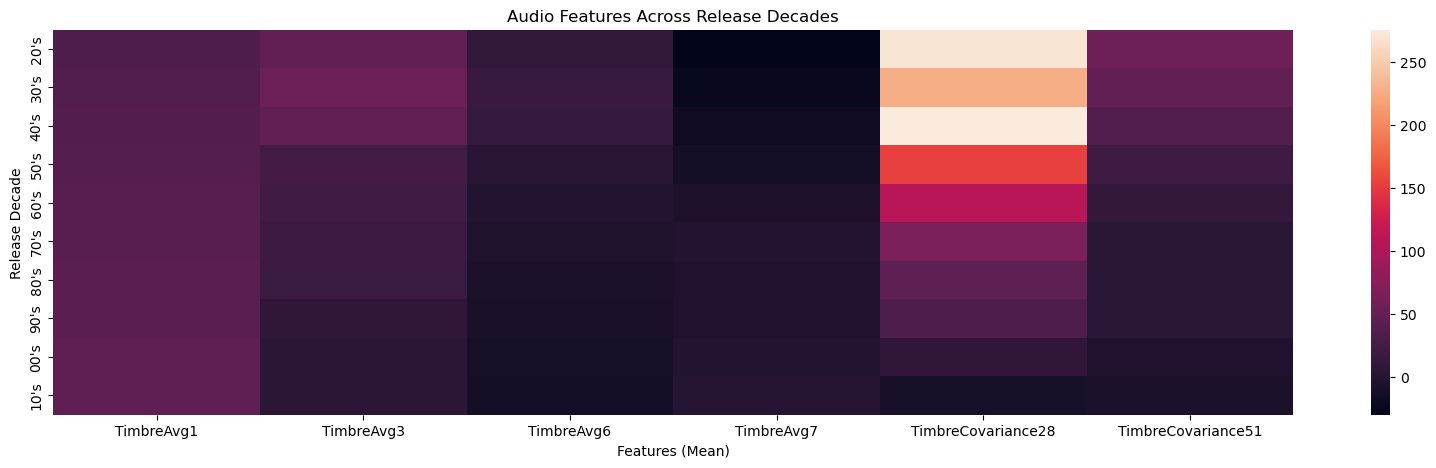

In [374]:
columns = music2.groupby(['Decade']).mean().columns
labels = ["{:02d}'s".format(l%100) for l in sorted(music2.Decade.unique())]
fig, ax = plt.subplots(figsize=(20,5)) 
sns.heatmap(music2.groupby(['Decade']).mean().iloc[:,0:20], yticklabels=labels)
plt.ylabel("Release Decade")
plt.xlabel("Features (Mean)")
plt.title("Audio Features Across Release Decades")
plt.show()

<p style="font-size:18px;">
</p>

<ul style="font-size:18px;">
    <li>Shifts in audio features imply changes in music trends and technology over the decades.</li>
    <li>TimbreCovariance28 shows potential for predicting music release decades due to its variability.</li>
    <li>The lack of variation in other features suggests they may not significantly determine release decades.</li>
</ul>


## Outliers

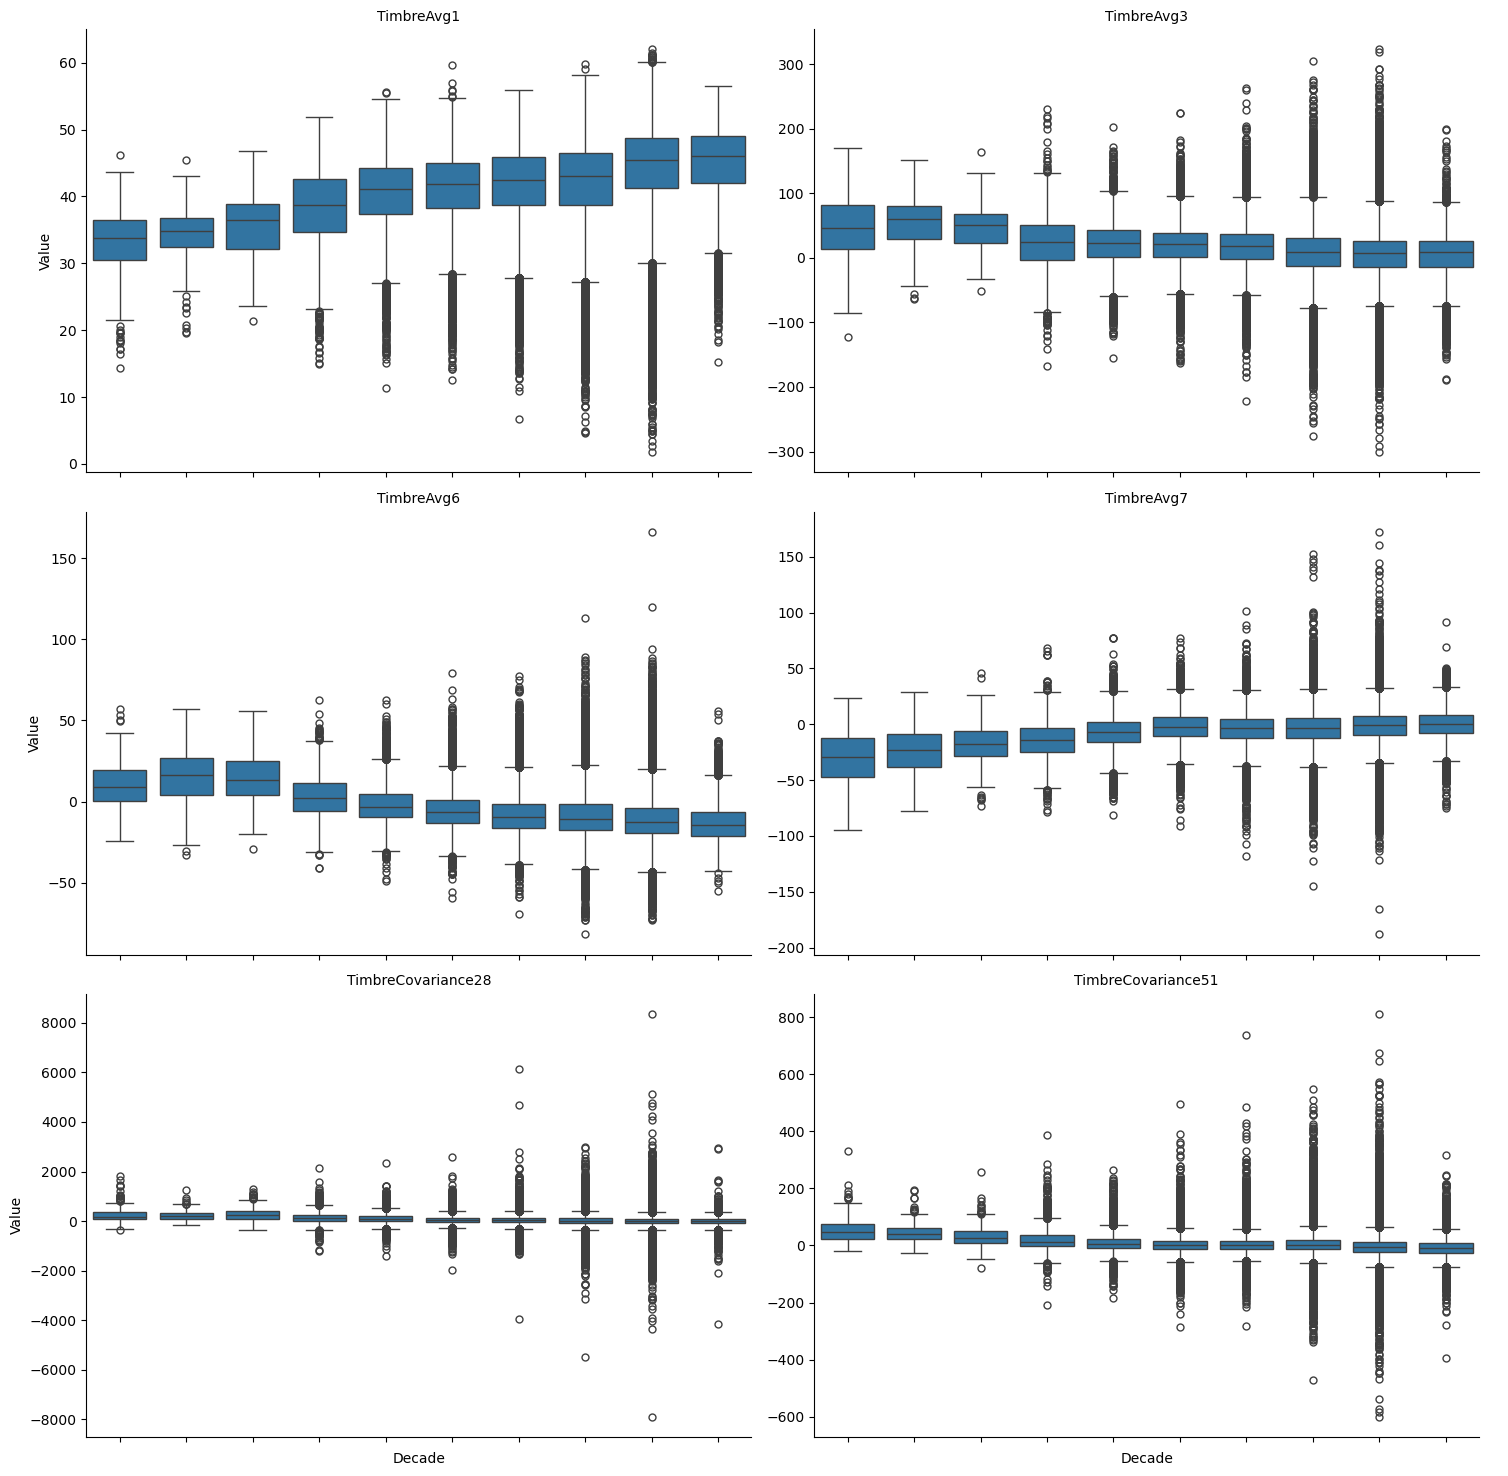

In [377]:
features_to_plot = music2.columns.difference(['Decade']) 
df_long = music2.melt(id_vars='Decade', value_vars=features_to_plot, var_name='Feature', value_name='Value')

g = sns.catplot(
    data=df_long, 
    kind='box',
    x='Decade', 
    y='Value', 
    col='Feature',
    col_wrap=2, 
    sharey=False,
    height=5, 
    aspect=1.5 
)

g.set_xticklabels(rotation=45)
g.set_titles("{col_name}")
plt.show()

<p style="font-size:20px;">
</p>

<ul style="font-size:20px;">
    <li>Substantial outliers are observed in all features, indicating extensive variation in audio properties.</li>
    <li>These outliers may signal diverse musical styles, genre-specific traits, or shifts in music production over time.</li>
    <li>Addressing these outliers is vital for ensuring the integrity of further statistical analysis and predictive model development.</li>
</ul>


## Skewness

Skewness of features:
 TimbreAvg1           -0.895509
TimbreAvg3           -0.153320
TimbreAvg6            0.847079
TimbreAvg7           -0.198829
TimbreCovariance28    0.205552
TimbreCovariance51    0.832129
dtype: float64


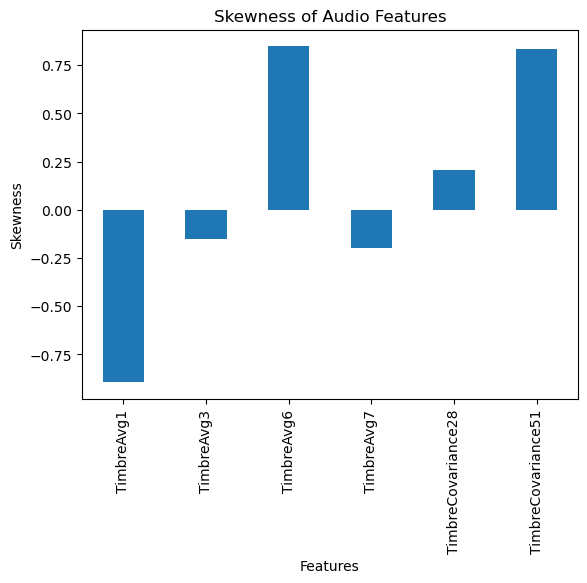

In [380]:
feature_skewness = music2.drop('Decade', axis=1).skew()
print("Skewness of features:\n", feature_skewness)

feature_skewness.plot(kind='bar')
plt.title('Skewness of Audio Features')
plt.ylabel('Skewness')
plt.xlabel('Features')
plt.show()

<p style="font-size:20px;">
</p>

<ul style="font-size:20px;">
<li>TimbreAvg1 has negative skewness, indicating that the distribution of this feature is weighted towards higher values, with fewer songs showing lower values. 
<li>TimbreAvg3, TimbreCovariance28, and TimbreAvg7 show skewness near zero, suggesting a more symmetric distribution. 
<li>TimbreAvg6 and TimbreCovariance51 exhibit positive skewness, implying that most songs have lower values for these features. 
</ul>
    

<p style="font-size:20px;">Skewness across various audio features indicates the need for data normalization to enhance the robustness of our prediction model. This suggests that data transformations, such as logarithmic or square root adjustments, may be beneficial before training.</p>

# Preprocessing

## Train - Test split

In [385]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8,random_state=24)

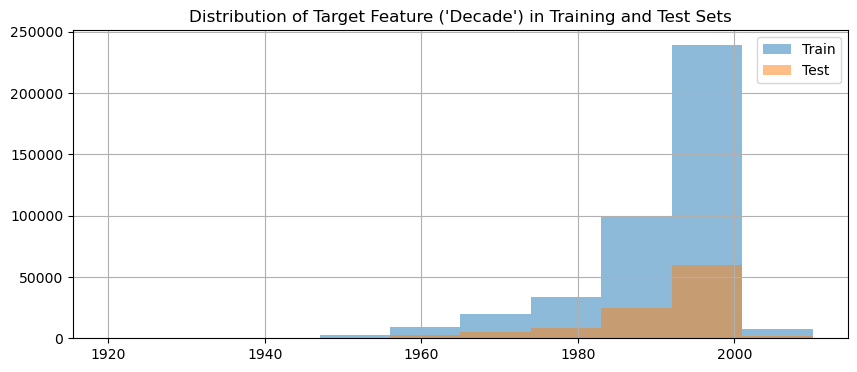

In [386]:
fig, ax = plt.subplots(figsize=(10,4))
y_train.hist(ax=ax, alpha=0.5, label='Train')
y_test.hist(ax=ax, alpha=0.5, label='Test')
ax.legend()
ax.set_title('Distribution of Target Feature (\'Decade\') in Training and Test Sets')
plt.show()

<p style="font-size:20px;">The proportion of instances for each 'Decade' is consistent across the training and test datasets.</p>

## Caps Extreme Outliers

<p style="font-size:20px;">Cap extreme outliers based on the IQR method.</p>

In [390]:
X_train = cap_extreme_outliers_iqr(X_train)
X_test = cap_with_reference(X_test, X_train)

## Handle With Skewness

<p style="font-size:20px;">We identify and transform skewed features in the dataset using a PowerTransformer when skewness is significant. This transformation enhances the data distribution for improved modeling.</p>

In [393]:
skewed_features = X_train.apply(skew)
skewed_features = skewed_features[abs(skewed_features) > 1]  # Select features with skewness > 1 or < -1

if not skewed_features.empty:
    transformer = PowerTransformer(method='yeo-johnson')  # Handles both positive and negative values
    X_train[skewed_features.index] = transformer.fit_transform(X_train[skewed_features.index])
    X_test[skewed_features.index] = transformer.transform(X_test[skewed_features.index])

## Data Scaling


In [395]:
# Applying feature scaling
X_train_scaled, X_test_scaled = scale_features(X_train, X_test)

# Basic Model

**<p style="font-size:20px;">We use it as a reference model<p>**

<p style="font-size:18px;">
Model Used: XGBoost, known for its speed and performance, is especially effective for handling large datasets and complex classification challenges.
</p>

<p style="font-size:18px;">Validation Method: 10-fold Cross-Validation. Averaging results across all folds helps reduce variability and ensures more consistent performance metrics.</p>

<p style="font-size:16px;">skip it and load the output from a file</p>

In [400]:
#y_pred, _ = basic_model_and_evaluate(X_train_scaled, y_train, X_test_scaled, run_model=True)

Directly load pre-computed outcomes from a file to save time.

In [402]:
y_pred, _ = basic_model_and_evaluate(X_train_scaled, y_train, X_test_scaled, run_model=False)

Cross-validated Macro Precision: 0.56 ± 0.09
Cross-validated Macro Recall: 0.21 ± 0.01
Cross-validated Macro F1: 0.25 ± 0.01


<p style="font-size:18px;">
    When dealing with imbalanced dataset, it is crucial to use metrics like <b>macro</b> precision, recall, F1 score, and balanced accuracy for accurate model evaluation:
</p>

<ul style="font-size:18px;">
    <li><strong>Macro Precision and Recall:</strong> These metrics calculate precision and recall for each class independently and then average them, giving equal weight to all classes. This prevents majority classes from skewing the results and ensures balanced consideration of all classes.</li>
    <li><strong>Macro F1 Score:</strong> The harmonic mean of precision and recall offers a comprehensive view of the model's balance between these metrics, capturing its ability to handle both effectively.</li>
    <li><strong>Balanced Accuracy:</strong> This metric averages each class's recall, providing a balanced assessment of the model's ability to identify true positives across all classes.</li>
</ul>

<p style="font-size:18px;">
    Together, these metrics offer a holistic evaluation of a model's performance on imbalanced datasets, ensuring that each class's representation is accurately considered.
</p>


In [404]:
XGBoost_base = get_classification_report_metrics([calculate_classification_metrics(y_test, y_pred)], 'XGBoost')
XGBoost_base 

,Macro Precision,Macro Recall,Macro F1 Score,Balanced Accuracy
XGBoost,0.521944,0.213758,0.252448,0.213758


<p style="font-size:18px;">
</p>

<ul style="font-size:18px;">
    <li>The model shows a cross-validated Macro Precision of 0.54 ± 0.08 and a Macro Recall of 0.21 ± 0.01. On the test set, the Macro Precision is 0.54, the Macro Recall is 0.22, the Macro F1 Score is 0.26, and the Balanced Accuracy is 0.22.</li>
    <li>Moderate precision with very low recall and F1 score indicates that the model is not identifying true positives effectively across all classes. This means that while the model's predictions may be accurate when it does predict a positive instance, it frequently fails to detect positive instances, leading to low recall and, consequently, a low F1 score.</li>
    <li>Low recall and balanced accuracy indicate a potential bias towards majority classes, overlooking minority classes.</li>
</ul>


<p style="font-size:20px;">We need to address the issue of imbalanced data to enhance the model's performance.</p>

#  Handling Imbalanced Data

### Random Under-Sampling:

<p style="font-size:18px;">we remove samples from the majority classes to balance the class distribution.
This technique helps prevent the model from being overwhelmed by the majority class and improves its ability to 
accurately classify minority class instances.</p>

In [410]:
# Apply under-sampling to the training set
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

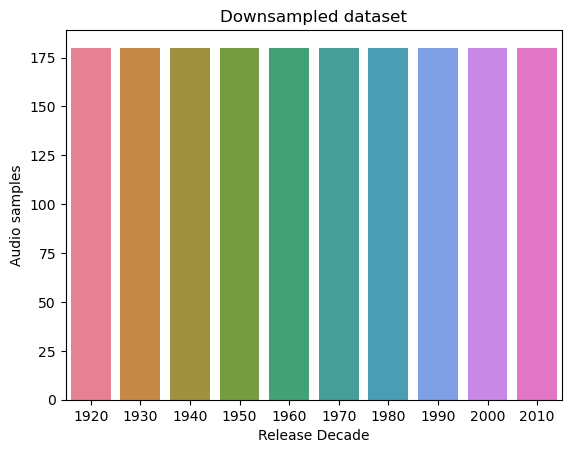

In [411]:
y_resampled_df = pd.DataFrame({'Decade': y_train_resampled})
sns.countplot(x="Decade", data=y_resampled_df, palette="husl")
plt.ylabel("Audio samples")
plt.xlabel("Release Decade")
plt.title("Downsampled dataset")
plt.show()

<p style="font-size:18px;">The class distribution has been balanced effectively through Under-Sampling</p>

In [413]:
X_train_scaled, X_test_scaled = scale_features(X_train_resampled, X_test)
y_pred, _ = xgboost_model_and_evaluate(X_train_scaled, y_train_resampled, X_test_scaled)

In [414]:
XGBoost_RandomUnderSampling = get_classification_report_metrics([calculate_classification_metrics(y_test, y_pred)], 'XGBoost')
XGBoost_RandomUnderSampling

,Macro Precision,Macro Recall,Macro F1 Score,Balanced Accuracy
XGBoost,0.168203,0.411652,0.152094,0.411652


<p style="font-size:18px;">RandomUnderSampler was used to address class imbalance by reducing the number of samples in majority classes. If cross-validation were applied after this resampling, there would be a risk of data leakage. This is because the rebalanced data would be present in both the training and test sets, leading to over-optimistic performance estimates.</p>

<p style="font-size:18px;">
</p>

<h3>Model Performance:</h3>

<ul style="font-size:18px;">
    <li>The model's <strong>Macro Precision</strong> has decreased from 0.54 to 0.17, indicating that the model is making more erroneous predictions and labeling more negative cases as positive.</li>
    <li>However, the <strong>Macro Recall</strong> has increased from 0.22 to 0.41, suggesting that the model is better at identifying all relevant instances across classes.</li>
    <li>The <strong>Macro F1 Score</strong> has decreased from 0.26 to 0.15, reflecting the skew towards recall over precision.</li>
    <li>The <strong>Balanced Accuracy</strong> has increased from 0.22 to 0.41, indicating that the model might have a more balanced approach to treating each class equally.</li>
</ul>

<p style="font-size:18px;">
The model demonstrates a better recall and balanced accuracy, identifying more relevant instances and treating each class equally. However, its lower precision reflects a higher rate of false positives, emphasizing the need for further technique to balance the data.
</p>


## SMOTE

<p style="font-size:18px;">We employ the Synthetic Minority Oversampling Technique (SMOTE) to address data imbalance, aiming to improve the model's performance by ensuring better representation of minority classes.</p>

In [419]:
smote = SMOTE(random_state=42)

# Perform oversampling only on the training set
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

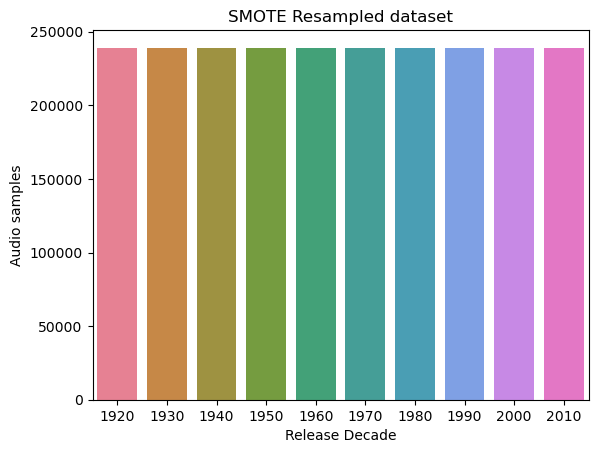

In [420]:
y_resampled_df = pd.DataFrame({'Decade': y_train_resampled})
sns.countplot(x="Decade", data=y_resampled_df, palette="husl")
plt.ylabel("Audio samples")
plt.xlabel("Release Decade")
plt.title("SMOTE Resampled dataset")
plt.show()

<p style="font-size:18px;">The class distribution has been balanced effectively through SMOTE</p>

In [422]:
# Applying feature scaling
X_train_scaled, X_test_scaled = scale_features(X_train_resampled, X_test)

<p style="font-size:16px;">skip it and load the output from a file</p>

In [424]:
#y_pred, _ = xgboost_SMOTE_model_and_evaluate(X_train_scaled, y_train_resampled, X_test_scaled, run_model=True)

Directly load pre-computed outcomes from a file to save time.

In [426]:
y_pred, _ = xgboost_SMOTE_model_and_evaluate(X_train_scaled, y_train_resampled, X_test_scaled, run_model=False)

In [427]:
XGBoost_SMOTE = get_classification_report_metrics([calculate_classification_metrics(y_test, y_pred)], 'XGBoost')
XGBoost_SMOTE

,Macro Precision,Macro Recall,Macro F1 Score,Balanced Accuracy
XGBoost,0.277735,0.44182,0.309436,0.44182


<p style="font-size:18px;">If cross-validation were applied after this oversampling, there would be a risk of data leakage. This is because synthetic data generated during SMOTE would be present in both the training and test sets, leading to over-optimistic performance estimates.<p>

<p style="font-size:18px;">
</p>

<h3>Model Performance:</h3>

<ul style="font-size:18px;">
    <li>The model's <strong>Macro Precision</strong> has decreased from 0.54 to 0.28, indicating that it is making more erroneous predictions and labeling more negative cases as positive.</li>
    <li>However, the <strong>Macro Recall</strong> has increased from 0.22 to 0.44, suggesting that the model is better at identifying all relevant instances across classes.</li>
    <li>The <strong>Macro F1 Score</strong> has increased from 0.26 to 0.31, reflecting a more balanced performance between precision and recall.</li>
    <li>The <strong>Balanced Accuracy</strong> has increased from 0.22 to 0.44, indicating a more balanced treatment of each class.</li>
</ul>

<p style="font-size:18px;">
Overall, the model shows improved recall and balanced accuracy, successfully identifying more relevant instances and treating each class equitably. However, its lower precision indicates a higher rate of false positives, suggesting the need for additional strategies to balance the data.
</p>


## BalancedBaggingClassifier

In [431]:
X_train_scaled, X_test_scaled = scale_features(X_train, X_test)

<p style="font-size:16px;">skip it and load the output from a file</p>

In [433]:
#res = Balanced_Bagging_Classifier(X_train_scaled, y_train, X_test_scaled, y_test, save_results=True)

<p style="font-size:16px;">Directly load pre-computed outcomes from a file to save time.</p>

In [435]:
res = Balanced_Bagging_Classifier(X_train_scaled, y_train, X_test_scaled, y_test, save_results=False)

In [436]:
indexes = []
processed_results = []
cv_results = []

for model_name, model_result,cv in res:
    indexes.append(model_name)
    processed_results.append(model_result)
    cv_results.append(cv)

In [437]:
BalancedBaggingClassifierget_report = get_classification_report_metrics(processed_results, indexes)
BalancedBaggingClassifierget_report

,Macro Precision,Macro Recall,Macro F1 Score,Balanced Accuracy
XGBoost,0.201739,0.481185,0.185540,0.481185
Random Forest,0.186588,0.457099,0.153960,0.457099
KNN,0.170728,0.430221,0.136839,0.430221


In [438]:
for metric, scores in cv_results[0].items():
    print(f"Cross-validated Macro {metric.capitalize()}: {scores.mean():.2f} ± {scores.std():.2f}")

Cross-validated Macro Precision: 0.20 ± 0.00
Cross-validated Macro Recall: 0.48 ± 0.02
Cross-validated Macro F1: 0.18 ± 0.00


<p style="font-size:18px;">
</p>

<h3>Model Performance: (XGBoost achieved higher scores across all metrics compared to other models)</h3>

<ul style="font-size:18px;">
    <li>The model's <strong>Macro Precision</strong> has decreased from 0.54 to 0.2, indicating that it is making more erroneous predictions and labeling more negative cases as positive.</li>
    <li>However, the <strong>Macro Recall</strong> has increased from 0.22 to 0.48, suggesting that the model is better at identifying all relevant instances across classes.</li>
    <li>The <strong>Macro F1 Score</strong> has decreased from 0.26 to 0.19, reflecting the skew towards recall over precision.</li>
    <li>The <strong>Balanced Accuracy</strong> has increased from 0.22 to 0.48, indicating a more balanced treatment of each class.</li>
</ul>

<p style="font-size:18px;">
Overall, the model demonstrates better recall and balanced accuracy, identifying more relevant instances and treating each class equally. However, its lower precision reflects a higher rate of false positives.
</p>


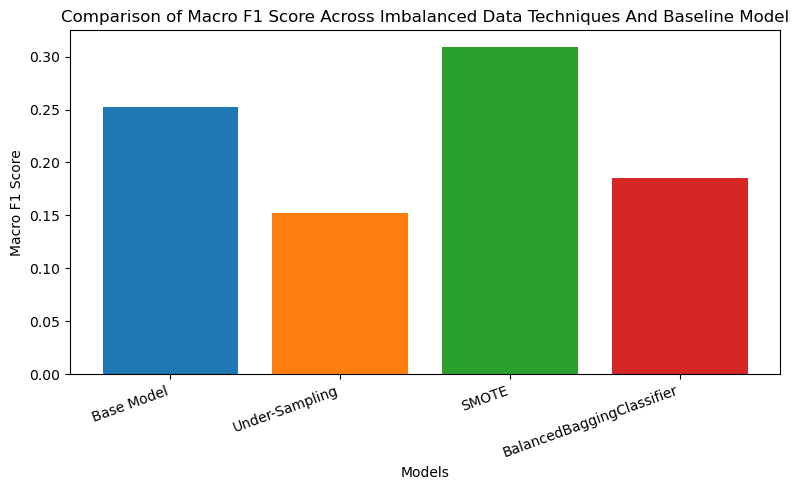

In [440]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

dict_f1 = {
    "Base Model" : XGBoost_base.loc["XGBoost", "Macro F1 Score"],
    "Under-Sampling" : XGBoost_RandomUnderSampling.loc["XGBoost", "Macro F1 Score"],
    "SMOTE" : XGBoost_SMOTE.loc["XGBoost", "Macro F1 Score"],
    "BalancedBaggingClassifier" : BalancedBaggingClassifierget_report.loc["XGBoost", "Macro F1 Score"][0]
}

plt.figure(figsize=(8, 5))
plt.bar(list(dict_f1.keys()), list(dict_f1.values()), color=colors)

plt.xlabel('Models')
plt.ylabel('Macro F1 Score')
plt.title('Comparison of Macro F1 Score Across Imbalanced Data Techniques And Baseline Model')
plt.xticks(rotation=20, ha='right')

plt.tight_layout()
plt.show()

<p style="font-size:20px;">SMOTE is the winner in the Macro F1 Score.<P>

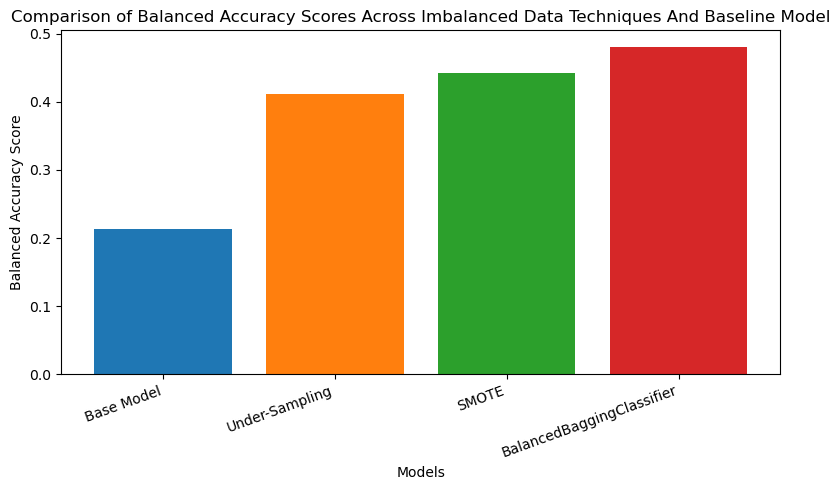

In [442]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

dict_Balanced_Accuracy = {
    "Base Model" : XGBoost_base.loc["XGBoost", "Balanced Accuracy"],
    "Under-Sampling" : XGBoost_RandomUnderSampling.loc["XGBoost", "Balanced Accuracy"],
    "SMOTE" : XGBoost_SMOTE.loc["XGBoost", "Balanced Accuracy"],
    "BalancedBaggingClassifier" : BalancedBaggingClassifierget_report.loc["XGBoost", "Balanced Accuracy"][0]
}

plt.figure(figsize=(8, 5))
plt.bar(list(dict_Balanced_Accuracy.keys()), list(dict_Balanced_Accuracy.values()), color=colors)

plt.xlabel('Models')
plt.ylabel('Balanced Accuracy Score')
plt.title('Comparison of Balanced Accuracy Scores Across Imbalanced Data Techniques And Baseline Model')
plt.xticks(rotation=20, ha='right')

plt.tight_layout()
plt.show()

<p style="font-size:20px;">BalancedBaggingClassifier is the winner in terms of Balanced Accuracy Score. We will continue with it.<p>

<p style="font-size:20px;">Given the current feature set, achieving a satisfactory model seems unlikely. Additional feature engineering is necessary to improve performance.<p>

# Better Feature Engineering

In [446]:
X['year'] = year
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=24)
X.drop('year', axis=1, inplace=True)
variances = X_train.var().sort_values(ascending=False) 

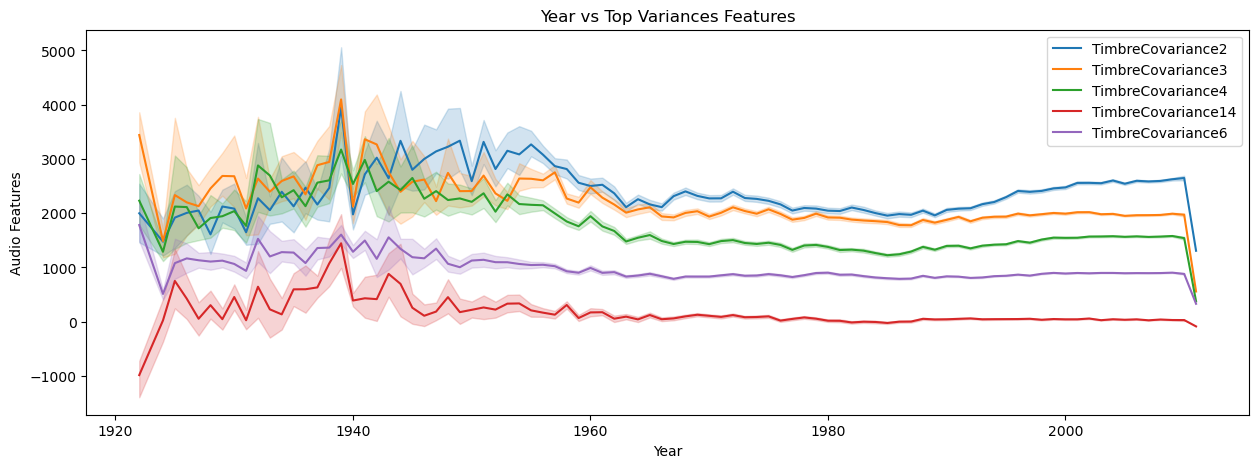

In [447]:
plt.figure(figsize=(15,5))
for i in variances.index[:5]:
    sns.lineplot(x=X_train['year'],y=X_train[i],label=i)
plt.title('Year vs Top Variances Features')
plt.xlabel('Year')
plt.ylabel('Audio Features')
plt.show()

<p style="font-size:20px;">This figure highlights significant variations in audio features over time, particularly in earlier decades, which gradually stabilized from the 1960s onward.</p>

**<p style="font-size:20px;">To reduce variations and capture trends over time, we calculate yearly means for each feature in the training data<p>**

In [450]:
# Calculate yearly means for training data
yearly_means_train = X_train.groupby('year').transform('mean')

# Append new columns for yearly means next to the original features in the training set
for column in X_train.columns:
    if column != 'year':  # Skip 'year'
        X_train[column + '_yearly_mean'] = yearly_means_train[column]

# Similarly for the test set (to prevent leakage)
yearly_means_test = X_test.groupby('year').transform('mean')
for column in X_test.columns:
    if column != 'year':
        X_test[column + '_yearly_mean'] = yearly_means_test[column]

X_train.drop('year', axis=1, inplace=True)
X_test.drop('year', axis=1, inplace=True)

X_train_scaled, X_test_scaled = scale_features(X_train, X_test)

**<p style="font-size:20px;">We focus on features that exhibit a strong correlation with the decade feature<p>**

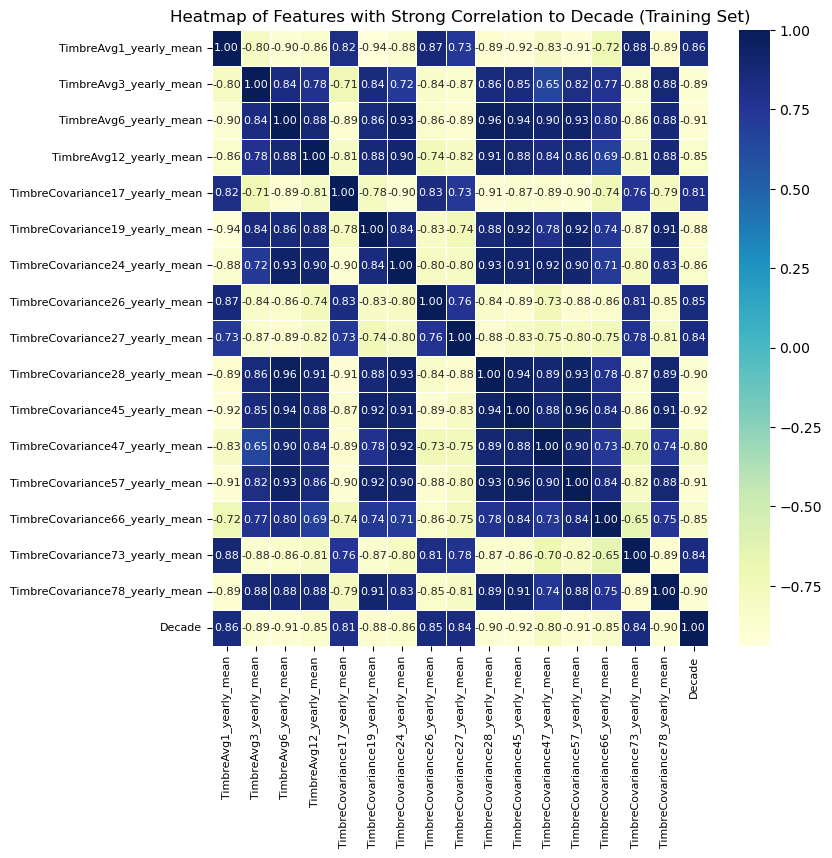

In [452]:
X_train_scaled['Decade'] = y_train.values

correlation_matrix = X_train_scaled.corr()
threshold = 0.8

strong_corrs_with_decade = correlation_matrix['Decade'][abs(correlation_matrix['Decade']) >= threshold]
features_with_strong_correlation = strong_corrs_with_decade.index.tolist()

plt.figure(figsize=(8, 8))
smaller_corr_matrix = X_train_scaled[features_with_strong_correlation].corr()
sns.heatmap(smaller_corr_matrix, annot=True, cmap="YlGnBu", cbar=True, linewidths=0.5, fmt=".2f", annot_kws={'size': 8})
plt.tick_params(axis='both', which='major', labelsize=8)
plt.title('Heatmap of Features with Strong Correlation to Decade (Training Set)')
plt.show()

X_train_scaled = X_train_scaled.drop(['Decade'], axis=1)
features_with_strong_correlation.remove('Decade')

<p style="font-size:20px;">We only observe the new features.<p>

<p style="font-size:20px;">Now, we proceed to train the BalancedBaggingClassifier exclusively on the features that have a correlation coefficient exceeding 0.8 with the decade variable.<p>

In [455]:
X_train_scaled = X_train_scaled[features_with_strong_correlation]
X_test_scaled = X_test_scaled[features_with_strong_correlation]

In [456]:
results = []
models = {}

base_classifiers = [
    ('XGBoost', XGBClassifier(objective='multi:softprob', eval_metric='logloss', use_label_encoder=False)),
    ('Random Forest', RandomForestClassifier()),
    ('KNN', KNeighborsClassifier())
]

for name, base_classifier in base_classifiers:
    bbc = BalancedBaggingClassifier(
        base_estimator=base_classifier,
        n_estimators=50, 
        random_state=42
    )

    bbc.fit(X_train_scaled, y_train)
    models[name] = bbc
    predictions = bbc.predict(X_test_scaled)
    results.append(calculate_classification_metrics(y_test, predictions))
    
get_classification_report_metrics(results, 'XGBoost', 'Random Forest', 'KNN')

,Macro Precision,Macro Recall,Macro F1 Score,Balanced Accuracy
XGBoost,0.870538,0.897408,0.882201,0.897408
Random Forest,0.865806,0.871638,0.867528,0.871638
KNN,0.947347,0.933897,0.933272,0.933897


<p style="font-size:18px;">KNN achieved the highest scores across all metrics, establishing it as our final model choice. With superior performance in all evaluation criteria, KNN demonstrates its effectiveness as the optimal model for our dataset.<p>

<p style="font-size:18px;">
</p>

<h3>Model Performance: (KNN)</h3>

<ul style="font-size:18px;">
    <li>The model's <strong>Macro Precision</strong> soared from 0.54 to an impressive 0.95, showcasing a remarkable enhancement in correctly identifying positive cases across all classes.</li>
    <li><strong>Macro Recall</strong> had a a phenomenal surge from 0.22 to an outstanding 0.93, indicating the model's exceptional ability to capture all relevant instances across classes with precision.</li>
    <li><strong>Macro F1 Score</strong> had a an extraordinary leap from 0.26 to an astounding 0.93, underscoring the model's unparalleled balance between precision and recall across all classes.</li>
    <li>The <strong>Balanced Accuracy</strong> surged from 0.22 to an exceptional 0.93, affirming a strikingly balanced performance across all classes.</li>
</ul>

<p style="font-size:18px;">
The KNN model's exceptional improvement over the baseline is evident in its significantly higher precision, recall, F1 score, and balanced accuracy. This underscores its exceptional capability in identifying relevant instances across all classes while maintaining a remarkably balanced approach in class prediction.
</p>


In [459]:
# final model
final_model = models['KNN']
y_pred = final_model.predict(X_test_scaled)
class_names = np.unique(y_test)

# Error analysis

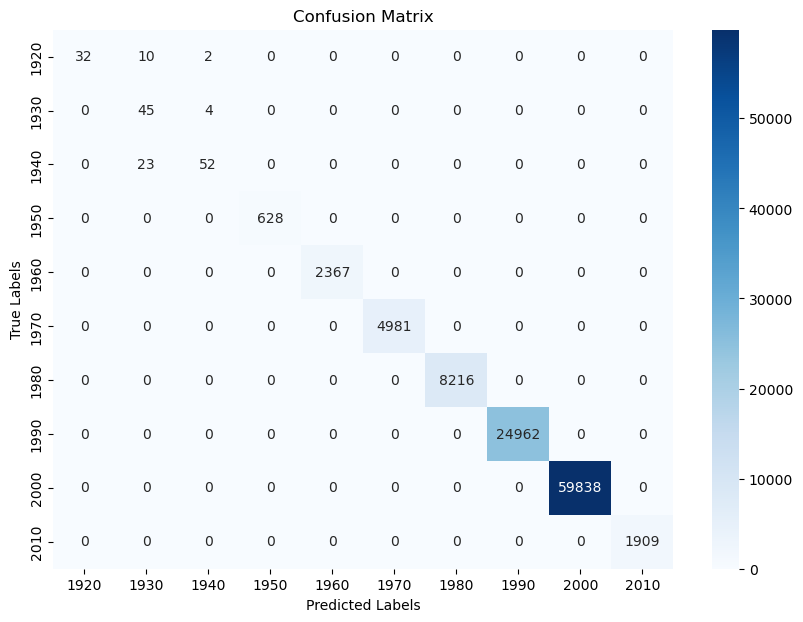

In [461]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_pred and y_true are your predictions and true labels respectively
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


<p style="font-size:20px;">
</p>

<ul style="font-size:20px;">
    <li>The matrix shows a high number of accurate classifications in the more recent decades, particularly from the 1970s onward. This suggests the model performs better at distinguishing recent data points, likely due to:
        <ul>
            <li>The availability of more data</li>
            <li>Clearer distinctions between recent decades</li>
        </ul>
    </li>
    <li>The model's ability to classify data into distinct decades effectively.</li>
    <li>There are relatively few cross-decade misclassifications, indicating the model's ability to discern differences between decades. However, earlier decades show some confusion, particularly between the 1920s, 1930s, and 1940s.
    </li>
    <li>The model's performance is less consistent for older decades, possibly due to limited data or fewer distinguishing features. This suggests that for these earlier periods, further refinements could enhance classification accuracy.</li>
</ul>

<p style="font-size:20px;">
Overall, the model appears suitable for classifying instances into distinct decades, particularly from the 1970s onward. For earlier periods, performance improvements might be needed to ensure reliable classifications across the decades.
</p>


## SHAP

<p style="font-size:16px;">skip it and load the output from a file<p>

In [465]:
# background_data = shap.maskers.Independent(X_train_scaled, max_samples=300)
# explainer = shap.Explainer(final_model.predict_proba, background_data)
# shap_values_errors = explainer(errors)

In [466]:
with open('shap_values_errors.pkl', 'rb') as file:
    # Load the SHAP values from the file
    shap_values_errors = pickle.load(file)

In [467]:
errors_index = y_pred != y_test
errors = X_test_scaled[errors_index.values]

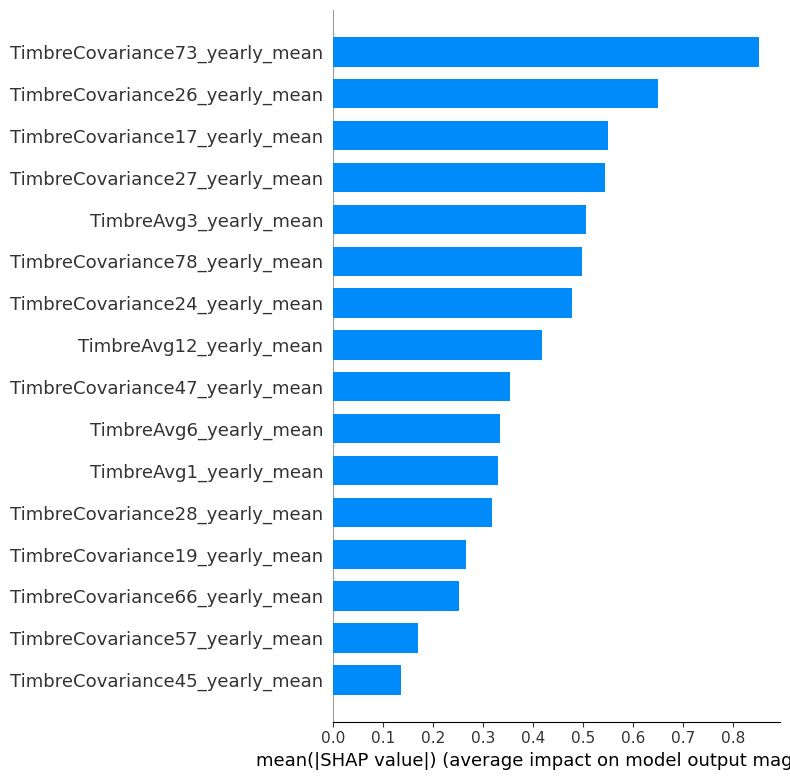

In [468]:
shap.initjs()
shap_values_errors_summed_across_classes = np.sum(np.abs(shap_values_errors.values), axis=2)
shap.summary_plot(shap_values_errors_summed_across_classes, errors, plot_type="bar")

<p style="font-size:20px;"><p>
<ul style="font-size:20px;">
 <li>The most impactful features include TimbreCovariance73_yearly_mean, TimbreCovariance26_yearly_mean, and TimbreCovariance17_yearly_mean. These features have the highest mean SHAP values, indicating that they significantly influence the model's errors.
 <li>The least influential features include TimbreCovariance28_yearly_mean, TimbreCovariance19_yearly_mean, TimbreCovariance66_yearly_mean, TimbreCovariance57_yearly_mean, and TimbreCovariance45_yearly_mean.
</ul>


### Final Model Analysis

<p style="font-size:16px;">skip it and load the output from a file</p>

In [472]:
# background_data = shap.maskers.Independent(X_train_scaled, max_samples=300)
# explainer = shap.Explainer(final_model.predict_proba, background_data)
# shap_values_300 = explainer(X_test_scaled[:300])

In [473]:
with open('shap_values1.pkl', 'rb') as file:
    # Load the SHAP values from the file
    shap_values_300 = pickle.load(file)

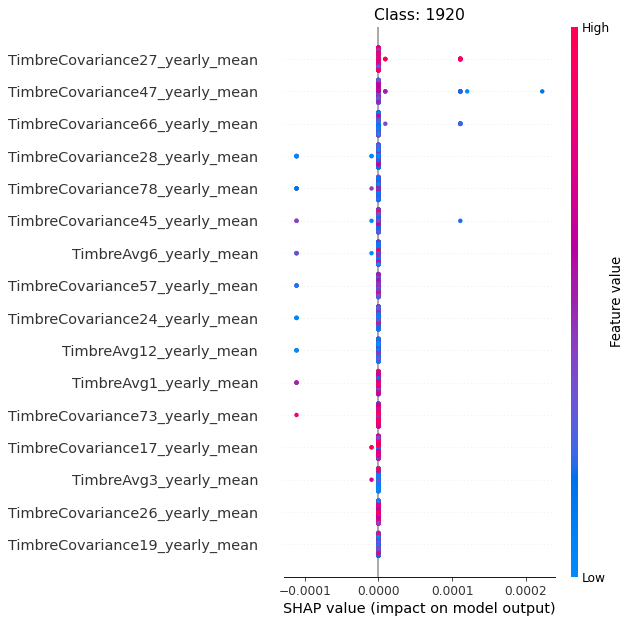

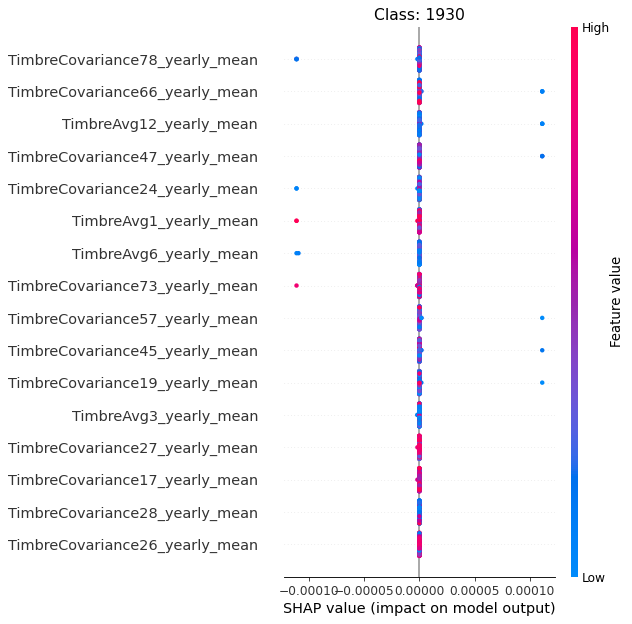

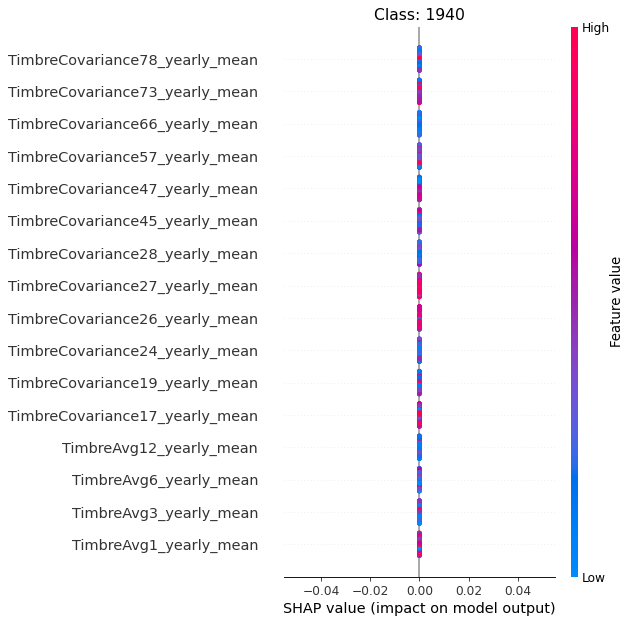

In [474]:
num_classes = len(final_model.classes_)

for i in range(3): 
    plt.figure(figsize=(10, 6), dpi=80)
    # Title for each plot
    plt.title(f"Class: {final_model.classes_[i]}", fontsize=14)
    shap.summary_plot(shap_values_300[:, :, i], X_test_scaled.iloc[:300], feature_names=X_test_scaled.columns, show=False)
    plt.tight_layout()
    plt.show()

<p style="font-size:20px;">These are the three decades where misclassifications occur.<p>

<p style="font-size:20px;">Similar features, such as TimbreCovariance78_yearly_mean, TimbreCovariance66_yearly_mean, and TimbreCovariance47_yearly_mean, appear near the top of the bar chart, indicating these features consistently have a significant impact on the model's output.<p>

<p style="font-size:20px;">As we can see, all features for these decades have SHAP values that cluster closely around zero, suggesting their contributions to the model output are relatively minor. This explains the mistakes in the earlier decades, as no feature strongly distinguishes each decade.
<p>

#### Feature Importance

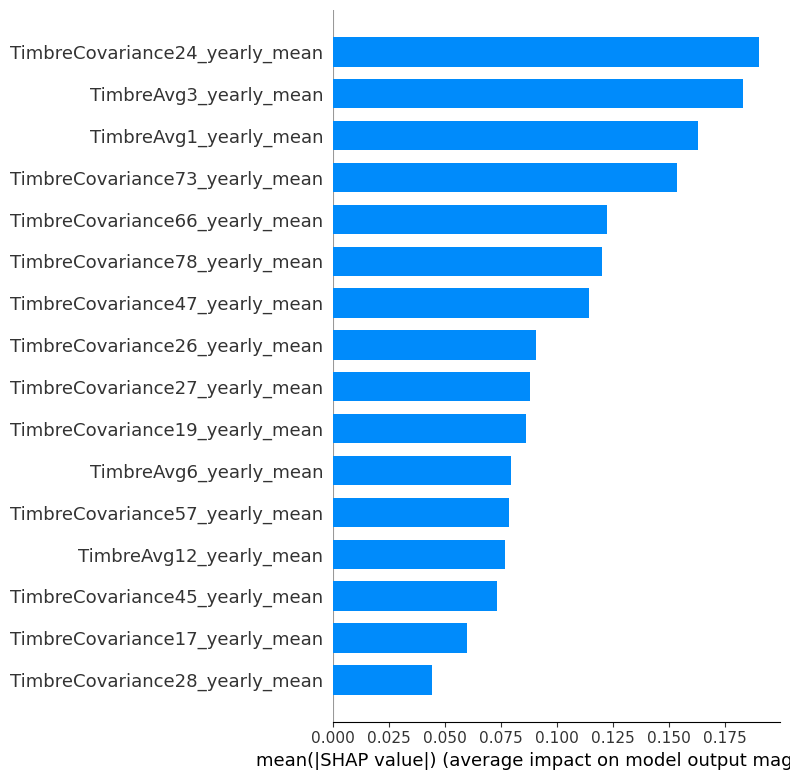

In [479]:
shap_values_summed_across_classes = np.sum(np.abs(shap_values_300.values), axis=2)
shap.summary_plot(shap_values_summed_across_classes, X_test_scaled.iloc[:300], plot_type="bar")

<p style="font-size:20px;"><p>
<ul style="font-size:20px;">
 <li>The most impactful features include TimbreCovariance24_yearly_mean, TimbreAvg3_yearly_mean, and TimbreAvg1_yearly_mean. These features have the highest mean SHAP values, indicating that they significantly influence the model's errors.
 <li>The least influential features include TimbreCovariance45_yearly_mean, TimbreCovariance17_yearly_mean, TimbreCovariance28_yearly_mean and TimbreAvg12_yearly_mean.
</ul>

In [481]:
X_train_scaled1 = X_train_scaled.drop(['TimbreAvg12_yearly_mean'], axis=1)
X_test_scaled1 = X_test_scaled.drop(['TimbreAvg12_yearly_mean'], axis=1)

In [482]:
results = []
models = {}

base_classifiers = [
    ('KNN', KNeighborsClassifier())
]

for name, base_classifier in base_classifiers:

    bbc = BalancedBaggingClassifier(
        base_estimator=base_classifier,
        n_estimators=50,
        random_state=42
    )

    bbc.fit(X_train_scaled1, y_train)
    models[name] = bbc
    predictions = bbc.predict(X_test_scaled1)
    results.append(calculate_classification_metrics(y_test, predictions))
    
get_classification_report_metrics(results,'KNN')

,Macro Precision,Macro Recall,Macro F1 Score,Balanced Accuracy
KNN,0.970171,0.962293,0.962179,0.962293


<p style="font-size:20px;">
We identified a feature with high importance for the model's errors but low overall importance. After removing this feature and refitting the model, all scores improved by 3%.
</p>

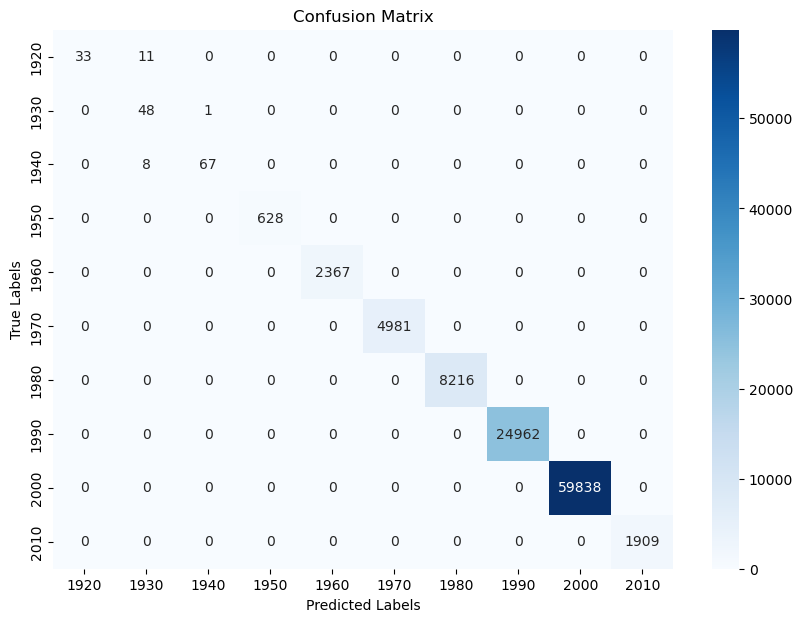

In [484]:
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


<p style="font-size:20px;">We observe a significant reduction in misclassifications!</p>

# Conclusion

<p style="font-size:20px;">
We were able to reach an almost perfect 96% balanced accuracy from a very low balanced accuracy , highlighting a significant improvement in the model's performance. This substantial improvement underscores the effectiveness of the adjustments made to the model.
<br>
These improvements were driven by adding new features to the dataset and treating the data as unbalanced. This approach significantly improved the model's ability to handle the class distribution effectively. This transformation affirms the model's exceptional performance and its ability to deliver outstanding results across all decades.</p>


<p style="font-size:20px;">
The existing notebooks for this dataset mostly focus on predicting the year of a song's release. The models tend to yield low-performance results, and there is no consideration for the imbalanced data. These notebooks are generally basic and short, demonstrating only basic models without delving into more sophisticated feature engineering techniques.
</p>

<p style="font-size:20px;">
In contrast, what we present here is fundamentally different. Our approach incorporates more comprehensive feature engineering, model optimization, and evaluation techniques, resulting in significantly higher performance metrics. By focusing on macro precision, recall, F1 score, and balanced accuracy, we provide a balanced evaluation of our model's performance across all decades. This comprehensive approach allows us to better handle the imbalanced data, delivering robust and reliable results.
<br><br>
We used this reference to address the imbalance in the data: https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/
</p>